In [1]:
!pip install -q qiskit
!pip install -q qiskit_aer
!pip install -q pylatexenc
!pip install -q qiskit_ibm_runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 87.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.9/363.9 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 11.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that 

In [20]:
from qiskit import QuantumCircuit,transpile
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
import numpy as np
from collections import Counter
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2, Session, Options
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt


In [11]:
from google.colab import userdata
key = userdata.get("IBM_key")

In [14]:
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token = key
)
backend = service.backend("ibm_sherbrooke")
print(backend)

/tmp/ipython-input-14-2533700599.py:1: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService(


<IBMBackend('ibm_sherbrooke')>


**2 spin state heisenberg model**

Taking the initial state |01> and finding probabilities of measuring |01> and |10> as functions of parameter time.

/usr/local/lib/python3.11/dist-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:1129: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


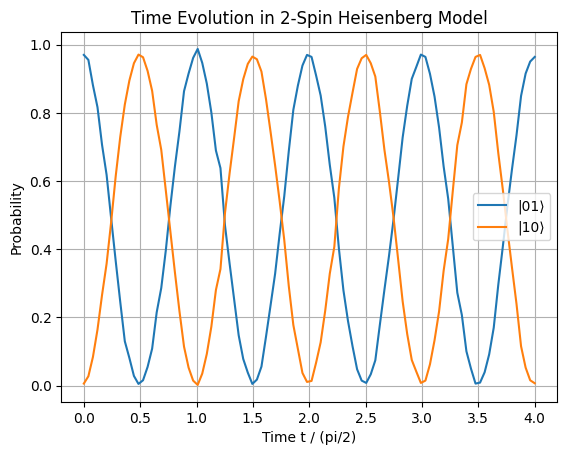

In [17]:
#initialising the parameters
J = 1.0
t = Parameter("time")
parametric_values = np.linspace(0, 2 * np.pi, 100)
params = [i/ (np.pi/2) for i in parametric_values]

#arrays to stroe the probabilities
prob_array_01 = []
prob_array_10 = []

qc2 = QuantumCircuit(2)
qc2.x(0)  #changing initial state to |01>

#time evolution gates
qc2.rxx(2 * J * t, 0, 1)
qc2.ryy(2 * J * t, 0, 1)
qc2.rzz(2 * J * t, 0, 1)

#measuring
qc2.measure_all()

qc2 = transpile(qc2,backend)

#creating pub list
pubs= [(qc2, [float(x)]) for x in parametric_values]

sampler= SamplerV2(backend)
job= sampler.run(pubs, shots=1024)
result= job.result()

#getting the probabilities
for i in range(len(parametric_values)):
    meas_array= result[i].data.meas.array.flatten()
    counts= Counter(meas_array)
    total= sum(counts.values())

    p_1= counts.get(1)/ total
    p_2= counts.get(2)/ total

    prob_array_01.append(p_1)
    prob_array_10.append(p_2)

#plotting
plt.plot(params, prob_array_01, label='|01⟩')
plt.plot(params, prob_array_10, label='|10⟩')
plt.xlabel("Time t / (pi/2)")
plt.ylabel("Probability")
plt.title("Time Evolution in 2-Spin Heisenberg Model")
plt.legend()
plt.grid(True)
plt.show()


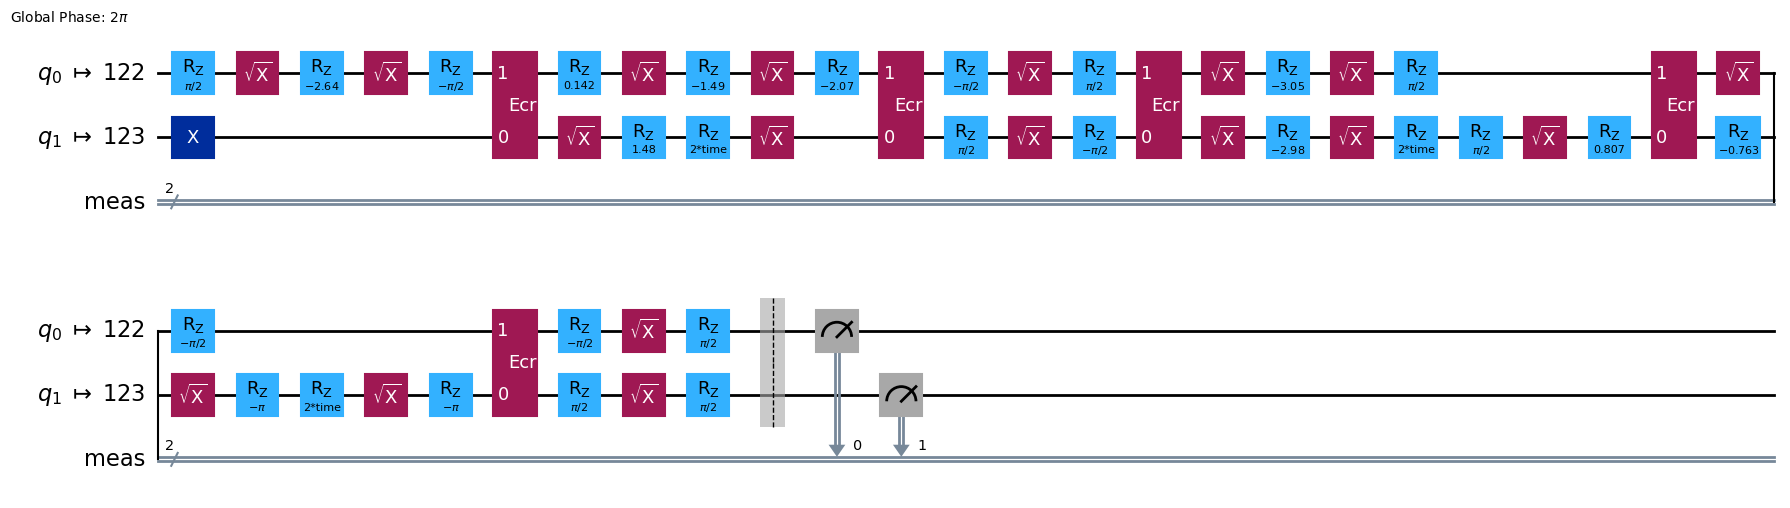

In [18]:
qc2.draw(output = 'mpl')

In [32]:
#initialising the parameters
J = 1.0 #coupling constant
t = np.pi/8 #taking specific case of t = pi/8 which creates a bell state in Aer simulator.

#initialising the circuit
qc2_new = QuantumCircuit(2)
qc2_new.x(0)  #changing initial state to |01>

#time evolution gates
qc2_new.rxx(2 * J * t, 0, 1)  # X0X1 term
qc2_new.ryy(2 * J * t, 0, 1)  # Y0Y1 term
qc2_new.rzz(2 * J * t, 0, 1)  # Z0Z1 term

#measuring
qc2_new.measure_all()

#stimualting
simulator = AerSimulator()
result = simulator.run(qc2_new, shots=1000).result()
counts = result.get_counts()
print("2-Spin Results:", counts)

2-Spin Results: {'01': 508, '10': 492}


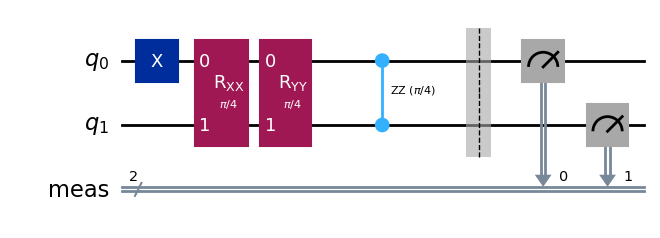

In [35]:
qc2_new.draw(output = 'mpl')

**3 spin state Heisenberg model**

|011> first changed (rotated by π/2 = 2 * t) when the gates where applied on 0th and 1st qubit giving 011 which then changed to 101 when the gates were applied on the 1st and the 2nd qubit.

/usr/local/lib/python3.11/dist-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:1129: UserWarning: IBM Quantum Platform is moving, and this version will be sunset on July 1. To get started on the new platform, read the migration guide at https://docs.quantum.ibm.com/migration-guides/classic-iqp-to-cloud-iqp
  warnings.warn(warning_message)


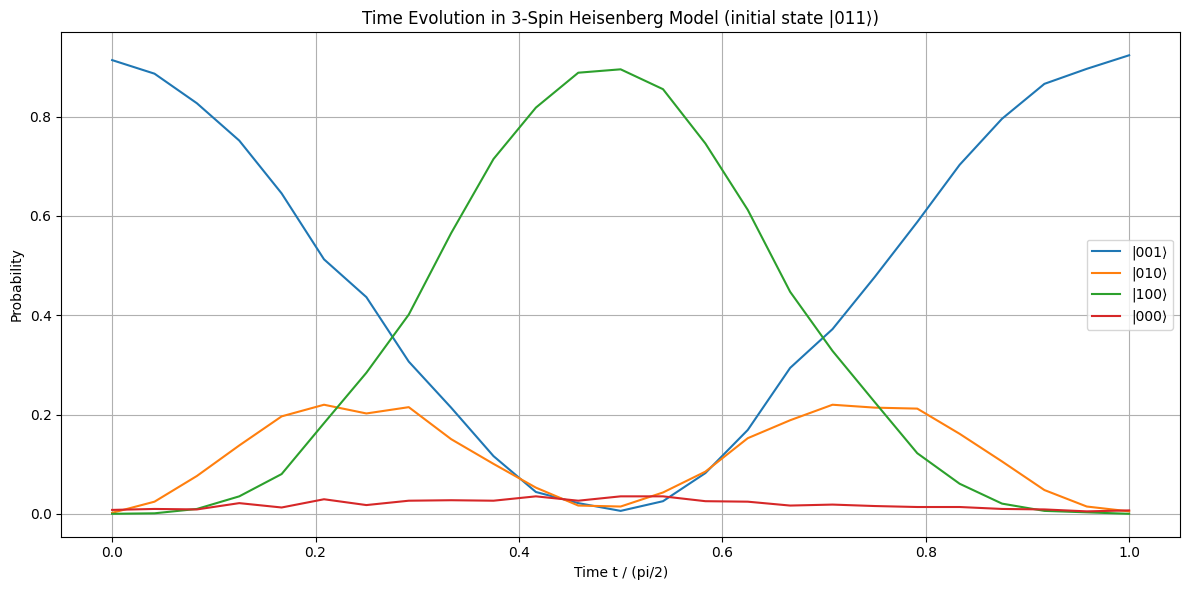

In [37]:
# Coupling constant
J = 1.0
t = Parameter("time")

#creating parametric values
parametric_values = np.linspace(0, np.pi/2,25)
params = [i/ (np.pi/2) for i in parametric_values]
#dictionary to store the probabilities for each state
state_probs = {
    '000': [], '001': [], '010': [], '011': [],
    '100': [], '101': [], '110': [], '111': []
}

qc3 = QuantumCircuit(3)
qc3.x(0)  #changing initial state to |001>
qc3.rxx(2*J*t, 0, 1)
qc3.ryy(2*J*t, 0, 1)
qc3.rzz(2*J*t, 0, 1)
qc3.rxx(2*J*t, 1, 2)
qc3.ryy(2*J*t, 1, 2)
qc3.rzz(2*J*t, 1, 2)
qc3.measure_all()

qc3 = transpile(qc3,backend)

#creating pub list
pubs= [(qc3, [float(x)]) for x in parametric_values]

sampler= SamplerV2(backend)
job= sampler.run(pubs, shots=1024)
result= job.result()

#taking the probabilities
for i in range(len(parametric_values)): # Calculate the probabilities of finding the system in the state |001>, |010> or |100> at a specific time 't'
    meas_array= result[i].data.meas.array.flatten()
    counts= Counter(meas_array)
    total= sum(counts.values())
    prob_1 = counts.get(1,0)/total
    prob_2 = counts.get(2,0)/total
    prob_4 = counts.get(4,0)/total
    prob_0 = counts.get(0,0)/total

    state_probs['000'].append(prob_0)
    state_probs['001'].append(prob_1)
    state_probs['010'].append(prob_2)
    state_probs['100'].append(prob_4)
#plotting the probabilities for selected states.
plt.figure(figsize=(12, 6))
for state in ['001', '010', '100', '000']:
    plt.plot(params, state_probs[state], label=f"|{state}⟩")

plt.xlabel("Time t / (pi/2)")
plt.ylabel("Probability")
plt.title("Time Evolution in 3-Spin Heisenberg Model (initial state |011⟩)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
